In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from google.colab import auth
import gspread
from google.auth import default
from gspread_dataframe import set_with_dataframe

url = "https://covid.ourworldindata.org/data/latest/owid-covid-latest.csv"
df = pd.read_csv(url)
print(df.head())

   iso_code continent        location last_updated_date  total_cases  \
0       AFG      Asia     Afghanistan        2024-06-02     235214.0   
1  OWID_AFR       NaN          Africa        2024-06-02   13142665.0   
2       ALB    Europe         Albania        2024-06-02     334863.0   
3       DZA    Africa         Algeria        2024-06-02     272033.0   
4       ASM   Oceania  American Samoa        2024-06-02       8359.0   

   new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0        0.0               0.000        7998.0         0.0   
1       36.0               5.143      259101.0         0.0   
2        0.0               0.000        3605.0         0.0   
3        1.0               0.143        6881.0         0.0   
4        0.0               0.000          34.0         0.0   

   new_deaths_smoothed  ...  male_smokers  handwashing_facilities  \
0                  0.0  ...           NaN                  37.746   
1                  0.0  ...           NaN               

In [ ]:
df_filtered = df[~df['iso_code'].str.contains('OWID')].copy()
df_filtered['case_fatality_rate'] = df_filtered['total_deaths'] / df_filtered['total_cases']
df_filtered = df_filtered.dropna(subset=['case_fatality_rate'])
df_filtered = df_filtered[df_filtered['total_cases'] > 0]

features = ['case_fatality_rate']
df_features = df_filtered[features].copy()

scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

kmeans = KMeans(n_clusters=3, random_state=42)
df_features['cluster'] = kmeans.fit_predict(df_features_scaled)
cluster_centers = kmeans.cluster_centers_.flatten()
cluster_labels = ['low', 'medium', 'high']

sorted_indices = cluster_centers.argsort()
label_map = {sorted_indices[i]: cluster_labels[i] for i in range(3)}

df_features['severity_label'] = df_features['cluster'].map(label_map)
df_filtered['severity_label'] = df_features['severity_label']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


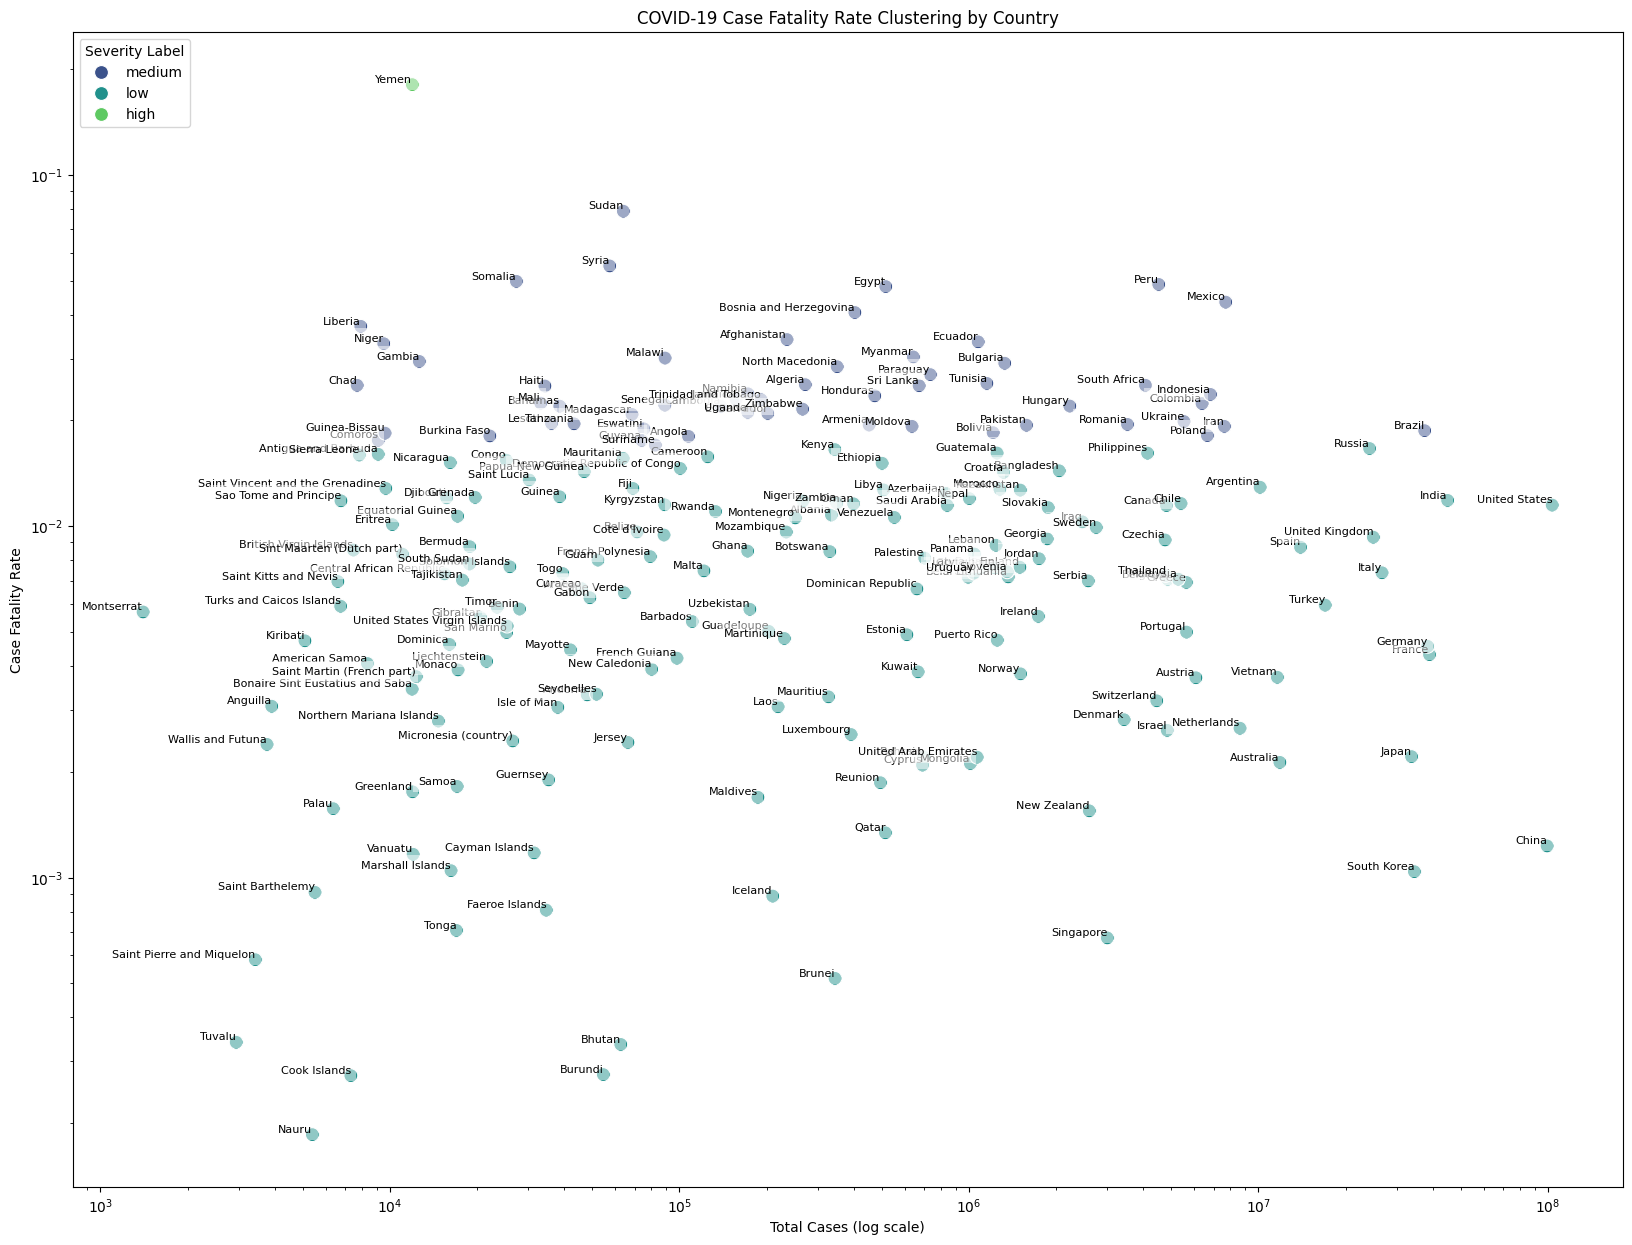

In [ ]:
plt.figure(figsize=(20, 15))
sns.scatterplot(data=df_filtered, x='total_cases', y='case_fatality_rate', hue='severity_label', palette='viridis', s=100)

for i in range(df_filtered.shape[0]):
    plt.text(x=df_filtered['total_cases'].iloc[i],
             y=df_filtered['case_fatality_rate'].iloc[i],
             s=df_filtered['location'].iloc[i],
             fontsize=8,
             ha='right',
             va='bottom',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.title('COVID-19 Case Fatality Rate Clustering by Country')
plt.xlabel('Total Cases (log scale)')
plt.ylabel('Case Fatality Rate')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Severity Label', loc='upper left')
plt.show()

In [ ]:

auth.authenticate_user()

creds, _ = default()
gc = gspread.authorize(creds)

sh = gc.create('Covid-19')
worksheet = sh.get_worksheet(0)
set_with_dataframe(worksheet, df_filtered)